In [1]:
# !pip install tensorflow

In [2]:

# %tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow_addons as tfa
import nibabel as nib
from pathlib import Path
import cv2
from model import unet
import json
import pandas as pd
# from segmentation_models import Unet as unet
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY'] = "1"


In [3]:
tf.__version__


'2.6.2'

In [4]:
tf.config.list_physical_devices('GPU')


[]

In [5]:
tf.config.list_physical_devices('CPU')


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
# read only constant
MODEL_GRAVEYARD = Path("./model_saved/channel_seperated_version")
IMG_GRAVEYARD = Path("./saved_img")

INPUT_SIZE = OUTPUT_SIZE = MASK_SIZE = (224, 224)
OUTPUT_CHANNELS = 3
INPUT_SHAPE = MASK_SHAPE = OUTPUT_SHAPE = (*OUTPUT_SIZE, OUTPUT_CHANNELS)
INTERMEDIATE_SIZE = (250, 250)

PIXEL_THRESHOLD = 100
BATCH_SIZE = 10
BUFFER_SIZE = 8
VAL_SUBSPLITS = 5
NUM_EPOCHS = 200
MIN_SHIFTING = -5
MAX_SHIFTING = 6
RANDOM_RADIAN_MAX = 15.0 * np.pi / 180
FOLDS = 5
MIN_INPUT_VALUE = 0
MAX_INPUT_VALUE = 1
WINDOWING_MIN_MAX = np.array(((0, 40), (0, 20), (20, 40)))
MAP_COLORS = np.array(
    [
        [0,   0,   0],  # black / layer
        #         [215, 175, 168], # brownish pink
        # [255,   0,   0],
        [56, 180, 139],  # green csf
                [ 50,  76, 172], # dark blue brain
        #         [ 66, 255, 255], # cyan

    ], dtype="uint8")


In [7]:
def create_mask(one_hot_mask):
    """
    (width, height, n_classes) -> (width, height, 1)
    (batch, width, height, n_classes) -> (batch, width, height, 1)
    """
    pred_mask = tf.argmax(one_hot_mask, axis=-1)
    return pred_mask[..., tf.newaxis]


In [8]:
def create_visible_mask(gt, mask, is_one_hot=False):
    if is_one_hot:
        mask = create_mask(mask)
    if tf.reduce_max(gt) <= 1.0:  # for floating-point `gt`, looking for better way to do this
        gt = gt * 255
    gt = tf.cast(gt, tf.int16)
    for i in range(OUTPUT_CHANNELS):
        gt = tf.where(mask == i, MAP_COLORS[i], gt)
    gt = tf.where(gt > 255, 255, gt)
    return gt


In [9]:
colors = [
    0,
    1,
    2
]


def create_one_hot_mask(mask, dtype):
    one_hot_map = []
    for color in colors:
        class_map = tf.reduce_all(tf.equal(mask, color), axis=-1)
        one_hot_map.append(class_map)

    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, dtype)
    return one_hot_map


In [10]:
def window_ct_v3(data_array, w_min, w_max, min_value=0, max_value=255, dtype="uint8"):
    if "float" in dtype:  # division is problem
        data_array = tf.cast(data_array, dtype)
    data_array = ((data_array - w_min) / (w_max - w_min)
                  * (max_value - min_value)) + min_value
    data_array = tf.where(data_array < min_value, min_value, data_array)
    data_array = tf.where(data_array > max_value, max_value, data_array)
    return tf.cast(data_array, dtype)


In [11]:
# @tf.function(experimental_compile=True)
def data_augmentation(image, mask):
    channels = image.shape[2]
    image = tf.image.resize(image, INTERMEDIATE_SIZE)
    mask = tf.image.resize(mask, INTERMEDIATE_SIZE)

    stacked_image = tf.stack([image, mask], axis=0)
    r_factor = tf.random.uniform(
        shape=[], minval=-1.0, maxval=1.0)  # scalar random
    stacked_image = tfa.image.rotate(
        stacked_image, r_factor * RANDOM_RADIAN_MAX, fill_value=-1000.0)  # filed with lowest value
    stacked_image = tf.image.random_crop(
        stacked_image, size=[2, *INPUT_SIZE, channels])  # shape (2, 224, 224, channels)
    return stacked_image


In [12]:
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001
    for i in range(OUTPUT_CHANNELS):

        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / \
            (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

        dice_score = 2 * ((intersection + smoothening_factor) /
                          (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score


In [13]:
def plot_loss(model_history, save_name=None):
    fig = plt.figure(figsize=(10, 5))
    if "val_loss" in model_history.history.keys():
        y = model_history.history["val_loss"]
        x = range(len(model_history.history["val_loss"]))
        l = plt.plot(x, y, "y", label="Validation loss")
        plt.scatter(x, y, c="y")

    plt.grid()
    y = model_history.history["loss"]
    x = range(len(model_history.history["loss"]))
    l = plt.plot(x, y, "g", label="loss")
    plt.scatter(x, y, c="g")

    plt.yscale("log")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    if save_name:
        fig.savefig(save_name)


In [14]:
def plot_mask_side_by_side(img, label=None, predicted_label=None, save_name=None, show=True, figsize=15):
    row = 3
    c = 1
    fig = plt.figure(figsize=(int(figsize*INPUT_SHAPE[2]/row), figsize))
    if predicted_label is None:
        row = 2
    img = window_ct_v3(img, tf.reduce_min(
        img), tf.reduce_max(img), 0, 1, "float32")

    for i in range(INPUT_SHAPE[2]):
        ax1 = fig.add_subplot(row, INPUT_SHAPE[2], c)
        ax1.set_title("gt%d w_min=%d, w_max=%d" %
                      (i, WINDOWING_MIN_MAX[i][0], WINDOWING_MIN_MAX[i][1]))
        ax1.imshow(img[..., i], cmap="gray")
        ax1.axis("off")
        c = c + 1

    if not label is None:
        for i in range(INPUT_SHAPE[2]):
            visible_mask = create_visible_mask(
                img[..., i][..., tf.newaxis], label, is_one_hot=True)
            ax4 = fig.add_subplot(row, INPUT_SHAPE[2], c)
            ax4.set_title("true mask on gt%d" % (i))
            ax4.imshow(visible_mask)
            ax4.axis("off")
            c = c + 1

    if not predicted_label is None:
        for i in range(INPUT_SHAPE[2]):
            visible_mask = create_visible_mask(
                img[..., i][..., tf.newaxis], predicted_label, is_one_hot=True)
            ax7 = fig.add_subplot(row, INPUT_SHAPE[2], c)
            ax7.set_title("predicted mask on gt%d" % (i))
            ax7.imshow(visible_mask)
            ax7.axis("off")
            c = c + 1

    if save_name:
        fig.savefig(str(save_name))
    if show:
        plt.show()
        print()
    fig.clear()
    plt.close(fig)


In [15]:
def create_generator_SI_fold(train_or_test, fold_index=FOLDS, with_name=False, augment=False):

    def parse_image():
        shifting_windowing = tf.zeros(shape=[WINDOWING_MIN_MAX.shape[0]])
        train_test_folds = json.load(open('folds5_42_val.json'))
        idx_all = train_test_folds[str(fold_index)][train_or_test]

        for img_path in idx_all:
            image = nib.load(img_path).get_fdata()
            mask_path = img_path.replace(
                '/s/', '/segment_mask_confidence1_contour/') # replace /s/ with folder of labeled mask
            mask = nib.load(mask_path).get_fdata()
            image = tf.convert_to_tensor(image)
            mask = tf.convert_to_tensor(mask)
            if augment and "train" in train_or_test:
                # augmentation include random crop, which will crop img to INPUT_SIZE, as well as mask
                image, mask = data_augmentation(image, mask)

            else:
                image = tf.image.resize(image, INPUT_SIZE)
                mask = tf.image.resize(mask, MASK_SIZE)

            for i in range(image.shape[2]):  # each slice
                if augment and "train" in train_or_test:
                    shifting_windowing = tf.random.uniform(shape=[WINDOWING_MIN_MAX.shape[0]],
                                                        minval=MIN_SHIFTING,
                                                        maxval=MAX_SHIFTING)
                new_image = np.ones(INPUT_SHAPE, dtype="float32")
                for j in range(INPUT_SHAPE[2]):
                    new_image[..., j] = window_ct_v3(image[..., i],
                                                    WINDOWING_MIN_MAX[j, 0] +
                                                    shifting_windowing[j],
                                                    WINDOWING_MIN_MAX[j, 1] +
                                                    shifting_windowing[j],
                                                    min_value=MIN_INPUT_VALUE,
                                                    max_value=MAX_INPUT_VALUE,
                                                    dtype="float32")

                new_mask = create_one_hot_mask(
                    mask[..., i, tf.newaxis], tf.uint8)
                new_image = tf.constant(new_image, dtype=tf.float32)
                if with_name:
                    new_postfix = "_%d.png" % (i)
                    new_img_name = img_path.replace(".nii", new_postfix)
                    yield new_image, new_mask, [new_img_name]
                else:
                    yield new_image, new_mask
    return parse_image


In [16]:
def load_dataset_Atfold(fold_index=FOLDS, augment=False, batch_size=BATCH_SIZE, num_epochs=None, buffer_size=BUFFER_SIZE, validation_split=0.2):

    # Update the JSON file name
    train_test_folds = json.load(open('folds5_42_val.json'))
    train_test_folds = train_test_folds[str(fold_index)]
    train_filepaths = train_test_folds["train"]
    val_filepaths = train_test_folds["val"]
    all_filepaths = train_filepaths + val_filepaths
    train_dataset = tf.data.Dataset.from_generator(
        create_generator_SI_fold(
            "train", fold_index=fold_index, augment=augment),
        output_signature=(
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
            tf.TensorSpec(shape=MASK_SHAPE, dtype=tf.uint8)
        )
    )
    train_dataset = train_dataset.shuffle(len(train_filepaths))
    train_dataset = train_dataset.repeat()

    val_dataset = tf.data.Dataset.from_generator(
        create_generator_SI_fold(
            "val", fold_index=fold_index, augment=augment),
        output_signature=(
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
            tf.TensorSpec(shape=MASK_SHAPE, dtype=tf.uint8)
        )
    )
    val_dataset = val_dataset.shuffle(len(val_filepaths))
    val_dataset = val_dataset.repeat()

    # Calculate the number of samples for training and validation
    num_train = len(train_filepaths)
    num_val = len(val_filepaths)
    print(num_train, num_val)

    # Batch and prefetch the datasets
    train_dataset = train_dataset.batch(
        batch_size).prefetch(buffer_size=buffer_size)
    val_dataset = val_dataset.batch(
        batch_size).prefetch(buffer_size=buffer_size)

    return train_dataset, val_dataset, num_train, num_val


In [17]:
def eval_metrics(model, train_or_test="test", fold_index=FOLDS-1):
    ds = tf.data.Dataset.from_generator(create_generator_SI_fold(train_or_test, fold_index=fold_index, with_name=False),
                                        output_signature=(tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
                                                          tf.TensorSpec(shape=MASK_SHAPE, dtype=tf.uint8)))
    METRIC = 4
    ds = ds.batch(METRIC)
    metric_iter = ds.as_numpy_iterator()
    gt_m, label_m = next(metric_iter)
    print(gt_m.shape, label_m.shape)
    pred_m = model(gt_m)
    metrics = class_wise_metrics(create_mask(
        label_m).numpy(), create_mask(pred_m).numpy())
    return metrics


## Load dataset and train the model

(224, 224, 3)
320 80
0
32 8
Epoch 1/2
32/32 [==============================] - 236s 7s/step - loss: 0.1301 - val_loss: 0.0359
Epoch 2/2
32/32 [==============================] - 222s 7s/step - loss: 0.0395 - val_loss: 0.0315
(4, 224, 224, 3) (4, 224, 224, 3)
fold 0
([0.9342514349522555, 1.0, 7.578053950001475e-10], [0.9660082635527493, 2.0, 1.515610790000295e-09])


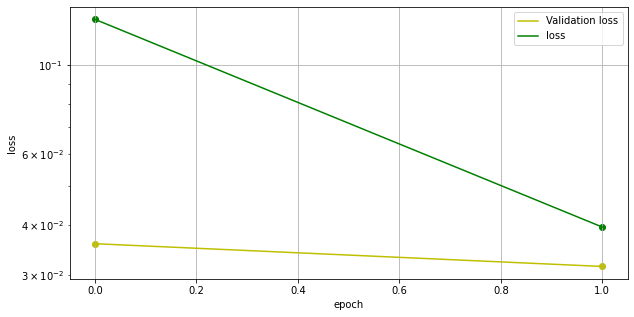

INFO:tensorflow:Assets written to: model_saved/channel_seperated_version/test_SPM12confidence1_focalloss_2epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold0/assets
320 80
1
32 8
Epoch 1/2
32/32 [==============================] - 237s 7s/step - loss: 0.1278 - val_loss: 0.0337
Epoch 2/2
32/32 [==============================] - 220s 7s/step - loss: 0.0357 - val_loss: 0.0257
(4, 224, 224, 3) (4, 224, 224, 3)
fold 1
([0.9979821029975495, 1.0, 2.4691357415028215e-08], [0.9989900325184851, 2.0, 4.938271483005643e-08])


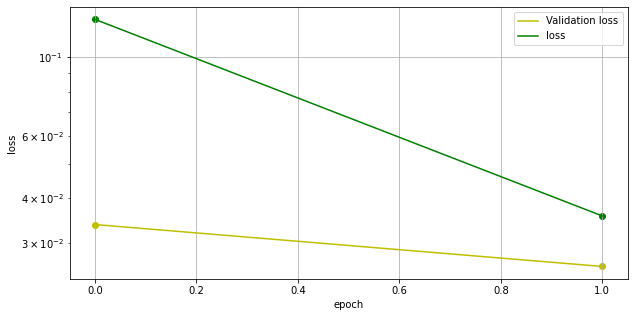

INFO:tensorflow:Assets written to: model_saved/channel_seperated_version/test_SPM12confidence1_focalloss_2epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold1/assets
320 81
2
32 8
Epoch 1/2
32/32 [==============================] - 233s 7s/step - loss: 0.1189 - val_loss: 0.0370
Epoch 2/2
32/32 [==============================] - 223s 7s/step - loss: 0.0333 - val_loss: 0.0253
(4, 224, 224, 3) (4, 224, 224, 3)
fold 2
([0.9822595376949815, 5.8719905703347595e-09, 0.00042427025790354214], [0.9910503837071145, 1.1743981140669519e-08, 0.0008481806597790911])


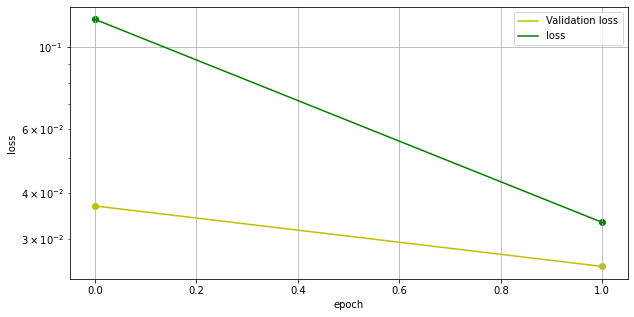

INFO:tensorflow:Assets written to: model_saved/channel_seperated_version/test_SPM12confidence1_focalloss_2epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold2/assets
320 81
3
32 8
Epoch 1/2
32/32 [==============================] - 238s 7s/step - loss: 0.1840 - val_loss: 0.0312
Epoch 2/2
32/32 [==============================] - 224s 7s/step - loss: 0.0338 - val_loss: 0.0254
(4, 224, 224, 3) (4, 224, 224, 3)
fold 3
([0.9879424426026415, 1.6233765970231073e-08, 5.543237219826845e-09], [0.9939346547015464, 3.2467531940462146e-08, 1.108647443965369e-08])


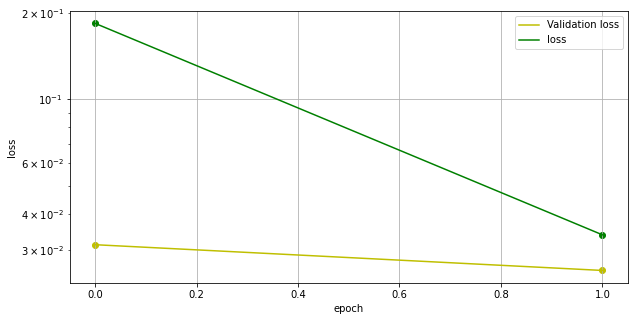

INFO:tensorflow:Assets written to: model_saved/channel_seperated_version/test_SPM12confidence1_focalloss_2epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold3/assets
320 81
4
32 8
Epoch 1/2
32/32 [==============================] - 233s 7s/step - loss: 0.1072 - val_loss: 0.0326
Epoch 2/2
32/32 [==============================] - 223s 7s/step - loss: 0.0336 - val_loss: 0.0241
(4, 224, 224, 3) (4, 224, 224, 3)
fold 4
([0.9611617107799963, 3.3333222222592593e-06, 1.2833675548211404e-09], [0.9801962841933524, 6.6666444445185185e-06, 2.566735109642281e-09])


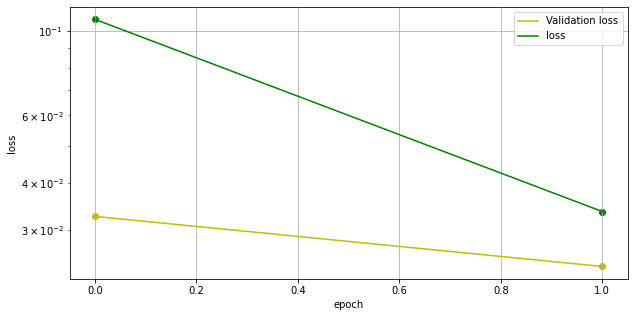

INFO:tensorflow:Assets written to: model_saved/channel_seperated_version/test_SPM12confidence1_focalloss_2epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold4/assets


In [18]:
INPUT_SHAPE = (*INPUT_SIZE, len(WINDOWING_MIN_MAX))
print(INPUT_SHAPE)
augment = False
epochs = NUM_EPOCHS
'''
naming dir_name for export segmentation model
'''
dir_name = f'test_SPM12confidence1_focalloss_%depochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold%d'

metrics_list = []
model_histories = []
model_list = []
for i in range(5):
    dir_name_i = dir_name % (epochs, i)
    model_dir_i = MODEL_GRAVEYARD / dir_name_i
    model_dir_i.parent.mkdir(parents=True, exist_ok=True)
    model_dir_i.mkdir(exist_ok=True)
    model_path = str(model_dir_i)
    

    LR_S = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=200,
        decay_rate=0.96,
        staircase=True)
    MC1 = tf.keras.callbacks.ModelCheckpoint(
        str(model_dir_i/"best_model.h5"),
        monitor='val_loss',
        save_best_only=True)
    MC2 = tf.keras.callbacks.ModelCheckpoint(
        str(model_dir_i/"last_model.h5"),
        monitor='val_loss',
        save_best_only=False)
    ES = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,  # Change this value to the desired threshold
        patience=10,  # Change this value to the desired number of consecutive epochs
        restore_best_weights=True,
    )
    train_i, val_dataset, num_train, num_val = load_dataset_Atfold(
        fold_index=i, augment=augment, num_epochs=epochs)
    print(i)
    train_steps_per_epoch = num_train // BATCH_SIZE
    validation_steps = num_val // BATCH_SIZE
    print(train_steps_per_epoch, validation_steps)
    model = unet((224, 224, 3), OUTPUT_CHANNELS)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_S),
                  loss=tfa.losses.SigmoidFocalCrossEntropy()
                  )
    model_history = model.fit(train_i,
                              epochs=epochs,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_dataset,
                              validation_steps=validation_steps,
                              callbacks=[MC1, MC2, ES])
    model_list.append(model)
    model_histories.append(model_history)
    m = eval_metrics(model, fold_index=i)
    metrics_list.append(m)
    print("fold %d" % i)
    print(m)
    plot_loss(model_history, str(model_dir_i / f'0-{epochs}epochs.png'))
    model.save(model_path)